# Deep Learning based Recommender System

As far as I've seen, recommendation systems mainly use nearest neighbour, matrix factorization methods as their backbone. Rarely, I saw projectes that uses image recognition(really rare) and NLP. Prime examples are MAANG companies and their services. 

This project uses Neural Collaborative Filtering (NCF). Scroll further to check what this is.

In my idea proposal, I mentioned tutorial that teach how to create recommendation system and I found out Collaborative Filtering.  It uses matrix factorization.

# Content:

* Creating DL based Movie Recommendation System with PyTorch Lightning
* The difference between implicit and explicit feedback for recommender systems
* Splitting dataset training our model without data leakages 
* Special metric for evaluating recommender systems - Hit Ratio metric.

# Building Recommender Systems using Implicit Feedback

Before we build our model, it is important to understand the distinction between *implicit* and *explicit* feedback in the context of recommender systems, and why modern recommender systems are built on implicit feedback.

[Link to the article](https://medium.com/analytics-vidhya/recommender-systems-explicit-feedback-implicit-feedback-and-hybrid-feedback-ddd1b2cdb3b)



# Data Preprocessing

Preprocessing data before creating a model

In [1]:
!pip install pytorch_lightning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm #progress bars on evaluation part

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader #methods to build the model
import pytorch_lightning as pl

np.random.seed(123)

First, we import the ratings dataset.

In [3]:
ratings = pd.read_csv('/content/ratings.csv', 
                      parse_dates=['timestamp']) #from MovieLens 25M Dataset

It's a huge dataset, so I preferred to use 40% of the dataset. Users from dataset were chosen randomly.

In [4]:
rand_userIds = np.random.choice(ratings['userId'].unique(), 
                                size=int(len(ratings['userId'].unique())*0.4), 
                                replace=False)

ratings = ratings.loc[ratings['userId'].isin(rand_userIds)]

print(f'There are {len(ratings)} rows of data from {len(rand_userIds)} users')

There are 605287 rows of data from 4249 users


In [5]:
ratings.sample(5) #random 5 rows

,userId,movieId,rating,timestamp
858990,5784,380,3.0,974662766
326483,2257,1252,5.0,1417995254
582663,3975,4306,4.0,1327170323
92222,702,1,4.5,1570859283
727641,4956,3967,4.0,1107579599


Here you can see user(user_id), who rated some movie(movie_id) with rating from 0.5 t0 5.0(rating). 

### Splitting the dataset

`timestamp` shows Unix epoch(seconds since Jan 01, 1970). For each user, the most recent review is used as the test set (i.e. leave one out), while the rest will be used as training data.

For example, last reviewed movie of user 67 was Avatar. That means, Avatar will be used as test data, whereas other reviewed movies will be training data. 

I couldn't split the data randomly, because it would mix user's last reviews with earlier one's. It won't lead to data leakage(I tested it before).

In [6]:
# Leave-one-out methodology
# Calculate the latest rating rank for each user
ratings['rank_latest'] = ratings.groupby(['userId'])['timestamp'] \
                                .rank(method='first', ascending=False)
                                
# Split the dataset into train and test sets based on the latest rating rank
train_ratings = ratings[ratings['rank_latest'] != 1]
test_ratings = ratings[ratings['rank_latest'] == 1]

# drop columns that we no longer need
train_ratings = train_ratings[['userId', 'movieId', 'rating']]
test_ratings = test_ratings[['userId', 'movieId', 'rating']]


### Converting the dataset into an implicit feedback dataset

MovieLens dataset uses explicit feedback. I converted them to 1's to make them implicit. 

1 - User rated movie.

It's done to predict whether the user will interact with movies, with the aim of presenting to users the movies with the highest interaction likelihood.






In [7]:
train_ratings.loc[:, 'rating'] = 1

train_ratings.sample(5)

,userId,movieId,rating
1094752,7388,4367,1
1156034,7792,1694,1
1264032,8537,7438,1
1239227,8376,3147,1
830085,5591,1088,1


Now, every rating is 1 which causes some troubles. We don't have negative reviews.

In code below, I generated negative samples with ratio 4:1. I read, that it's most likely to be real-life scenario(from 3:1 to 5:1).
[Negative to Postive ratio](https://www.etouchpoint.com/do-you-know-your-ratio-of-positive-to-negative-cx-feedback/)



In [8]:
# Get a list of all movie IDs
all_movieIds = ratings['movieId'].unique()

# Placeholders that will hold the training data
users, items, labels = [], [], []

# This is the set of items that each user has interaction with
user_item_set = set(zip(train_ratings['userId'], train_ratings['movieId']))

# 4:1 ratio of negative to positive samples
num_negatives = 4

for (u, i) in tqdm(user_item_set):
    users.append(u)
    items.append(i)
    labels.append(1) # items that the user has interacted with are positive
    for _ in range(num_negatives):
        # randomly select an item
        negative_item = np.random.choice(all_movieIds) 
        # checking whether user has not interacted with this item
        while (u, negative_item) in user_item_set:
            negative_item = np.random.choice(all_movieIds)
        users.append(u)
        items.append(negative_item)
        labels.append(0) # Movies that were not interacted - negative

  0%|          | 0/601038 [00:00<?, ?it/s]

Defining PyTorch Dataset to facilitate training. The class below encapsulates the code above into a PyTorch Dataset class.

In [9]:
class MovieLensTrainDataset(Dataset):
    """MovieLens PyTorch Dataset for Training
    
    Args:
        ratings (pd.DataFrame): Dataframe containing the movie ratings
        all_movieIds (list): List containing all movieIds
    
    """

    def __init__(self, ratings, all_movieIds):
        self.users, self.items, self.labels = self.get_dataset(ratings, all_movieIds)

    def __len__(self):
        return len(self.users)
  
    def __getitem__(self, idx):
        return self.users[idx], self.items[idx], self.labels[idx]

    def get_dataset(self, ratings, all_movieIds):
        users, items, labels = [], [], []
        user_item_set = set(zip(ratings['userId'], ratings['movieId']))

        num_negatives = 4
        for u, i in user_item_set:
            users.append(u)
            items.append(i)
            labels.append(1)
            for _ in range(num_negatives):
                negative_item = np.random.choice(all_movieIds)
                while (u, negative_item) in user_item_set:
                    negative_item = np.random.choice(all_movieIds)
                users.append(u)
                items.append(negative_item)
                labels.append(0)

        return torch.tensor(users), torch.tensor(items), torch.tensor(labels)

# Our model - Neural Collaborative Filtering (NCF)

I found this model great for this [project](https://towardsdatascience.com/neural-collaborative-filtering-96cef1009401)

### User Embeddings

An embedding is a low-dimensional space that captures the relationship of vectors from a higher dimensional space.

Ex.: User loves 2 genres - Comedy and thrillers movies.

1st dimension is - how much he loves comedy movies.
2nd dimension is - how much he loves thriller movies.

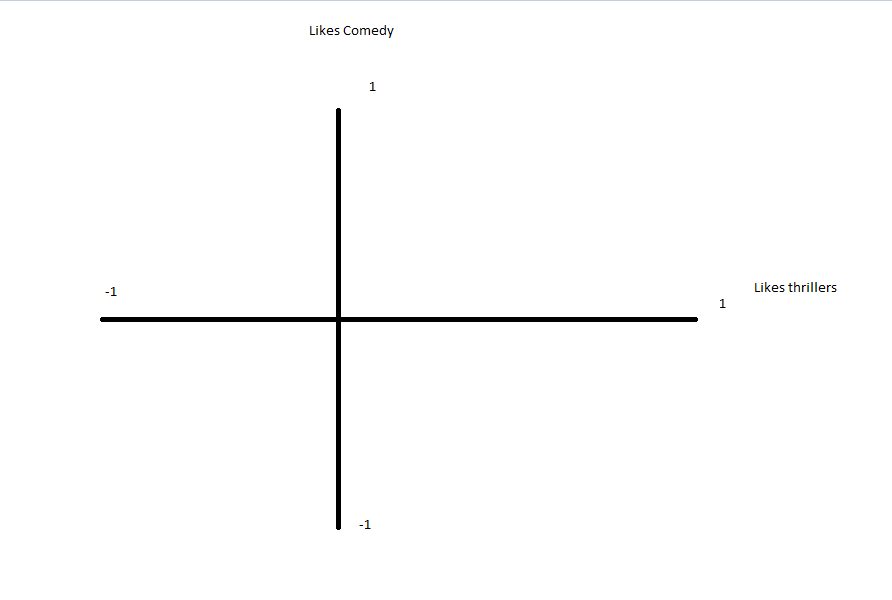

Let's say, Nurzhas loves thrillers, but doesn't likes thrillers. So, in graph, he would look like this:

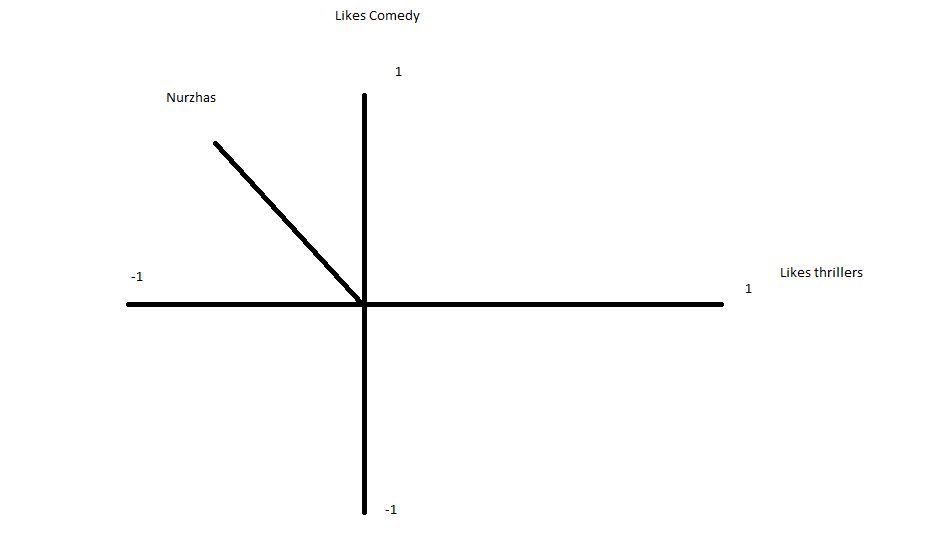

Other user, Yerasyl is opposite of Nurzhas.
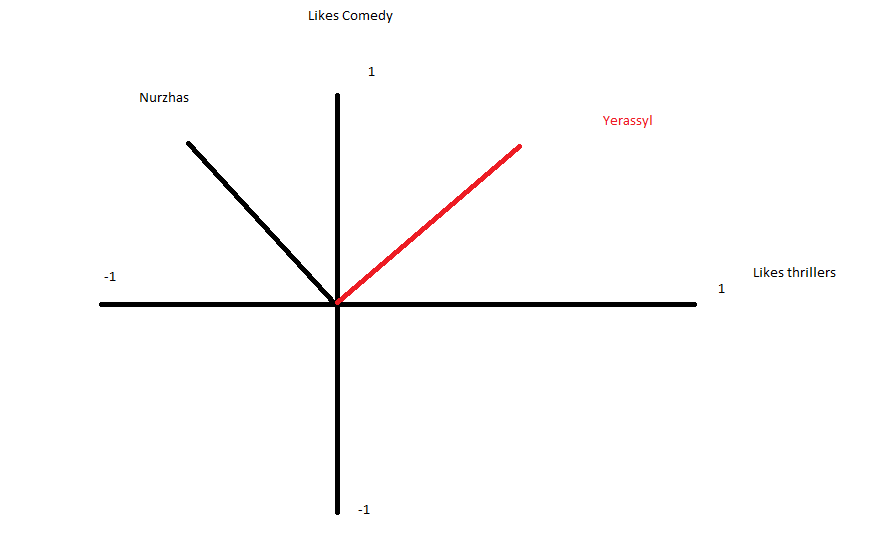

This is known as 2d embedding. Here we can easily track preferences of users in 2d linespace.

More dimensions = more traits of users. 
In this model exactly, I used 8d model.

### Learned Embeddings

Seperate movie embegging will be used to represent the traits of movies(in lowerd dimension).

How to automatically get weights for embeddings? Answers is - Collaborative Filteging.

By using the ratings dataset, we can identify similar users and movies, creating user and item embeddings learned from existing ratings.

### Model Architecture

User and movie(item) embeddings are key to the model.
 
Let's walk through the model architecture using the following training sample:

| userId | movieID | interacted |
|-|-|-|
| 17 | 4 | 1 |
here that's positive review, because user interacted with movie.

 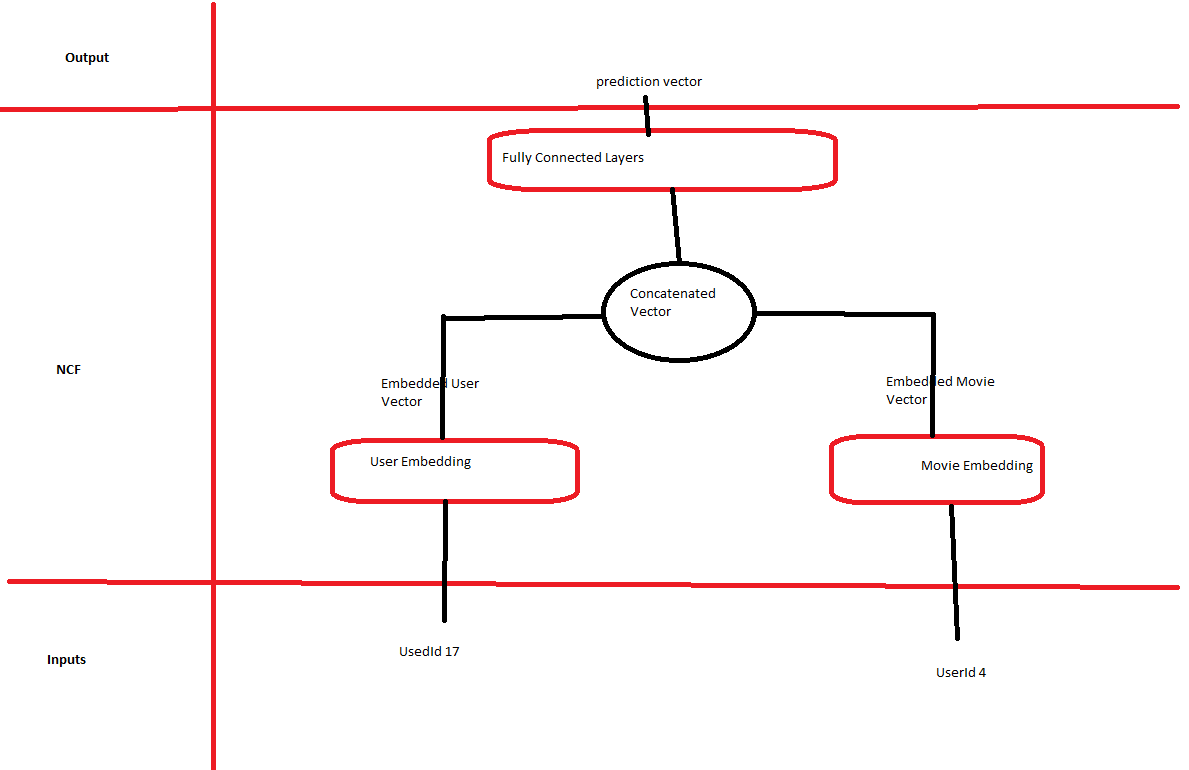

The user input vector and item input vector are fed to the user embedding and item embedding respectively, which results in a smaller, denser user and item vectors. 

The embedded user and item vectors are concatenated before passing through a series of fully connected layers, which maps the concatenated embeddings into a prediction vector as output. 

Finally, we apply a `Sigmoid` function to obtain the most probable class.

Let's create NCF model using PyTorch Lightning!

In [10]:
class NCF(pl.LightningModule):
    """ Neural Collaborative Filtering (NCF)
    
        Args:
            num_users (int): Number of unique users
            num_items (int): Number of unique items
            ratings (pd.DataFrame): Dataframe containing the movie ratings for training
            all_movieIds (list): List containing all movieIds (train + test)
    """
    
    # embedding layers for the users and items, and three fully connected (dense) layers with ReLU activation functions.
    def __init__(self, num_users, num_items, ratings, all_movieIds):
        super().__init__()
        self.user_embedding = nn.Embedding(num_embeddings=num_users, embedding_dim=8) #8 dimesional embedding
        self.item_embedding = nn.Embedding(num_embeddings=num_items, embedding_dim=8)
        self.fc1 = nn.Linear(in_features=16, out_features=64)
        self.fc2 = nn.Linear(in_features=64, out_features=32)
        self.output = nn.Linear(in_features=32, out_features=1)
        self.ratings = ratings
        self.all_movieIds = all_movieIds
        
    #embedding user and movie inputs, concatenates and passes through 3 dense layers(above function)
    def forward(self, user_input, item_input):
        
        # Pass through embedding layers
        user_embedded = self.user_embedding(user_input)
        item_embedded = self.item_embedding(item_input)

        # Concat the two embedding layers
        vector = torch.cat([user_embedded, item_embedded], dim=-1)

        # Pass through dense layer
        vector = nn.ReLU()(self.fc1(vector))
        vector = nn.ReLU()(self.fc2(vector))

        # Output layer
        pred = nn.Sigmoid()(self.output(vector))

        return pred
    
    #defining training step for the model and loss function is computing the loss
    def training_step(self, batch, batch_idx):
        user_input, item_input, labels = batch
        predicted_labels = self(user_input, item_input)
        loss = nn.BCELoss()(predicted_labels, labels.view(-1, 1).float()) #computing the loss
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters()) #specified Adam optimizer

    #defining trainnig data loader for the model. We take negative and positive reviews from dataset for training
    def train_dataloader(self): 
        return DataLoader(MovieLensTrainDataset(self.ratings, self.all_movieIds),
                          batch_size=512, num_workers=4)

Instantiating the NCF model using the class above

In [11]:
num_users = ratings['userId'].max()+1
num_items = ratings['movieId'].max()+1

all_movieIds = ratings['movieId'].unique()

model = NCF(num_users, num_items, train_ratings, all_movieIds)

Let's train our NCF model for 5 epochs using the GPU. 

In [14]:
trainer = pl.Trainer(max_epochs=5, gpus=1)

trainer.fit(model)

/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:474: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name           | Type      | Params
---------------------------------------------
0 | user_embedding | Embedding | 85.0 K
1 | item_embedding | Embedding | 1.7 M 
2 | fc1            | Linear    | 1.1 K 
3 | fc2            | Linear    | 2.1 K 
4 

Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


# Evaluating our Recommender System

I tried evaluating it with accurary or RMSE, but it didn't fit to the recommendation system evaluation.

Why? Because, user don't have to click on every item that he sees. Instead, we need him to click on one of the many items. As long as user obey this pattern, our system works great.

I simulated it's evaluation for 25 items that could be recommended for user.

- User have 99 items that he didn't click on.
- We combine it with 1 test item(remember Avater movie?)
- Run the model, and rantk them accordint to their probabilities.
- I chose top 25 movies from this 100 initial items. If test movie is there, then out model works.
- Repeat it for all users. The Hit Ratio is then the average hits.

This is Hit Ratio 25, and it's used in most of the modern recommendation systems.


### Hit Ratio 25

In [15]:
# User-item pairs for testing
test_user_item_set = set(zip(test_ratings['userId'], test_ratings['movieId']))

# Dict of all items that are interacted with by each user
user_interacted_items = ratings.groupby('userId')['movieId'].apply(list).to_dict()

hits = []
for (u,i) in tqdm(test_user_item_set):
    interacted_items = user_interacted_items[u]
    not_interacted_items = set(all_movieIds) - set(interacted_items)
    selected_not_interacted = list(np.random.choice(list(not_interacted_items), 99))
    test_items = selected_not_interacted + [i]
    
    predicted_labels = np.squeeze(model(torch.tensor([u]*100), 
                                        torch.tensor(test_items)).detach().numpy())
    
    top25_items = [test_items[i] for i in np.argsort(predicted_labels)[::-1][0:25].tolist()]
    
    if i in top25_items:
        hits.append(1)
    else:
        hits.append(0)
        
print("The Hit Ratio 25 is {:.2f}".format(np.average(hits)))

  0%|          | 0/4249 [00:00<?, ?it/s]

The Hit Ratio 25 is 0.90


To put this into context, what this means is that 90% of the users were recommended the actual item (among a list of 25 items) that they eventually interacted with.